#Installing PySpark & Hadoop

In [1]:
# Installing Java (required for Spark)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [2]:
# Setting Java environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [3]:
# Installing PySpark
!pip install pyspark
!pip install findspark

In [4]:
# Initializing Spark
import findspark
findspark.init()

# importing all necessary modules

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan
from pyspark.sql.functions import median
from pyspark.sql.functions import mean, stddev
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import OneVsRest
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

#Loading Data &  Cleaning

In [6]:
# Initializing Spark session
spark = SparkSession.builder \
    .appName("UsedCarAnalysis") \
    .getOrCreate()

In [7]:
# Loading dataset
data = spark.read.csv("/content/car_prices.csv", header=True, inferSchema=True)

In [8]:
# Showing schema & data
data.printSchema()

root
 |-- year: integer (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- trim: string (nullable = true)
 |-- body: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- vin: string (nullable = true)
 |-- state: string (nullable = true)
 |-- condition: integer (nullable = true)
 |-- odometer: integer (nullable = true)
 |-- color: string (nullable = true)
 |-- interior: string (nullable = true)
 |-- seller: string (nullable = true)
 |-- mmr: integer (nullable = true)
 |-- sellingprice: integer (nullable = true)
 |-- saledate: string (nullable = true)



In [9]:
data.show(5)

+----+-----+-------------------+----------+-----+------------+-----------------+-----+---------+--------+-----+--------+--------------------+-----+------------+--------------------+
|year| make|              model|      trim| body|transmission|              vin|state|condition|odometer|color|interior|              seller|  mmr|sellingprice|            saledate|
+----+-----+-------------------+----------+-----+------------+-----------------+-----+---------+--------+-----+--------+--------------------+-----+------------+--------------------+
|2015|  Kia|            Sorento|        LX|  SUV|   automatic|5xyktca69fg566472|   ca|        5|   16639|white|   black|kia motors americ...|20500|       21500|Tue Dec 16 2014 1...|
|2015|  Kia|            Sorento|        LX|  SUV|   automatic|5xyktca69fg561319|   ca|        5|    9393|white|   beige|kia motors americ...|20800|       21500|Tue Dec 16 2014 1...|
|2014|  BMW|           3 Series|328i SULEV|Sedan|   automatic|wba3c1c51ek116351|   ca|    

In [10]:
# Checking missing values
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+----+-----+-----+-----+-----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+
|year| make|model| trim| body|transmission|vin|state|condition|odometer|color|interior|seller|mmr|sellingprice|saledate|
+----+-----+-----+-----+-----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+
|   0|10301|10399|10651|13195|       65352|  4|    0|    11820|      94|  749|     749|     0| 38|          12|      12|
+----+-----+-----+-----+-----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+



In [11]:
# Dropping rows where critical columns are missing
critical_cols = ["sellingprice", "year", "make", "model", "odometer"]
data_clean = data.dropna(subset=critical_cols)

In [12]:
data_clean = data_clean.fillna({
    "trim": "Unknown",
    "transmission": "Unknown",
    "color": "Unknown",
    "interior": "Unknown",
    "condition": 3
})

In [13]:
# Dropping the 4 rows with missing VIN
data_final = data_clean.dropna(subset=["vin"])

In [14]:
mmr_median = data_final.select(median("mmr")).collect()[0][0]
data_final = data_final.fillna({"mmr": mmr_median})

In [15]:
# Verify cleaning
print(f"Rows after cleaning: {data_clean.count()}")

Rows after cleaning: 548336


In [16]:
# Calculating mean ± 3σ for odometer
stats = data_clean.select(
    mean("odometer").alias("mean"),
    stddev("odometer").alias("stddev")
).collect()

mean_odo = stats[0]["mean"]
stddev_odo = stats[0]["stddev"]

# Filter outliers (3 standard deviations)
data_clean = data_clean.filter(
    (col("odometer") > (mean_odo - 3*stddev_odo)) &
    (col("odometer") < (mean_odo + 3*stddev_odo)))

# Drop the 4 rows with missing VIN after outlier filtering
data_clean = data_clean.dropna(subset=["vin"])

# Fill nulls in mmr after outlier filtering
mmr_median = data_clean.select(median("mmr")).collect()[0][0]
data_clean = data_clean.fillna({"mmr": mmr_median})

# Exploratory Data Analysis

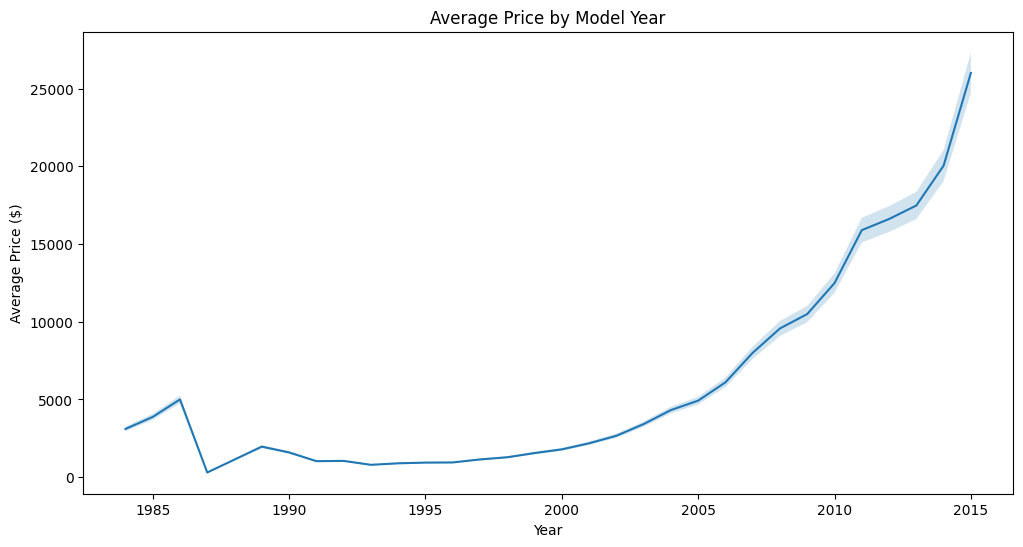

In [17]:
year_price = data_clean.groupBy('year').agg(
    mean('sellingprice').alias('avg_price'),
    count('*').alias('count')
).orderBy('year').toPandas()

plt.figure(figsize=(12,6))
sns.lineplot(x='year', y='avg_price', data=year_price)
plt.fill_between(year_price['year'],
                year_price['avg_price']*0.95,
                year_price['avg_price']*1.05, alpha=0.2)
plt.title('Average Price by Model Year')
plt.xlabel('Year')
plt.ylabel('Average Price ($)')
plt.show()

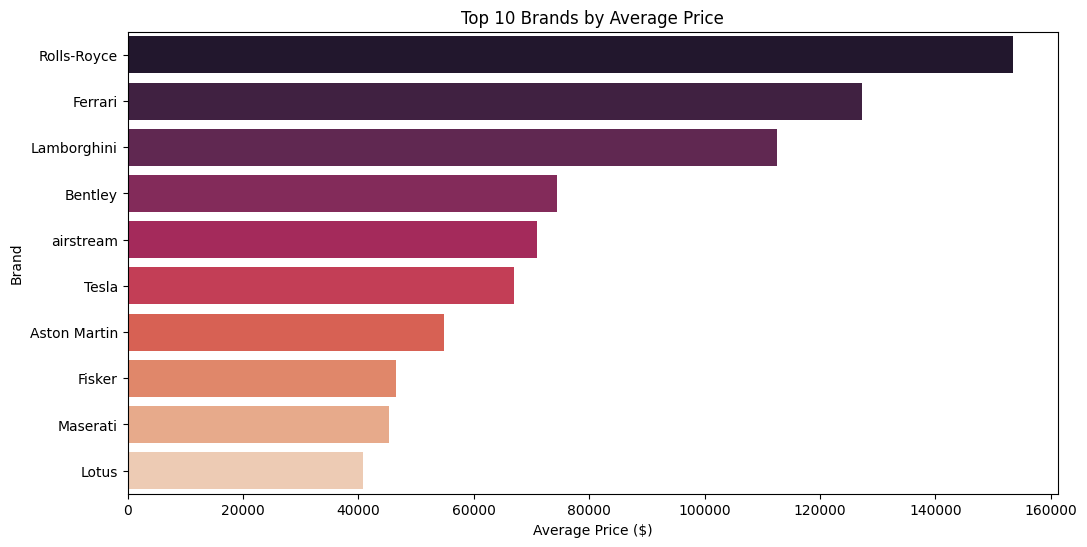

In [18]:
brand_price = data_clean.groupBy('make').agg(
    mean('sellingprice').alias('avg_price'),
    count('*').alias('count')
).orderBy('avg_price', ascending=False).limit(10).toPandas()

plt.figure(figsize=(12,6))
sns.barplot(x='avg_price', y='make', data=brand_price, palette='rocket')
plt.title('Top 10 Brands by Average Price')
plt.xlabel('Average Price ($)')
plt.ylabel('Brand')
plt.show()

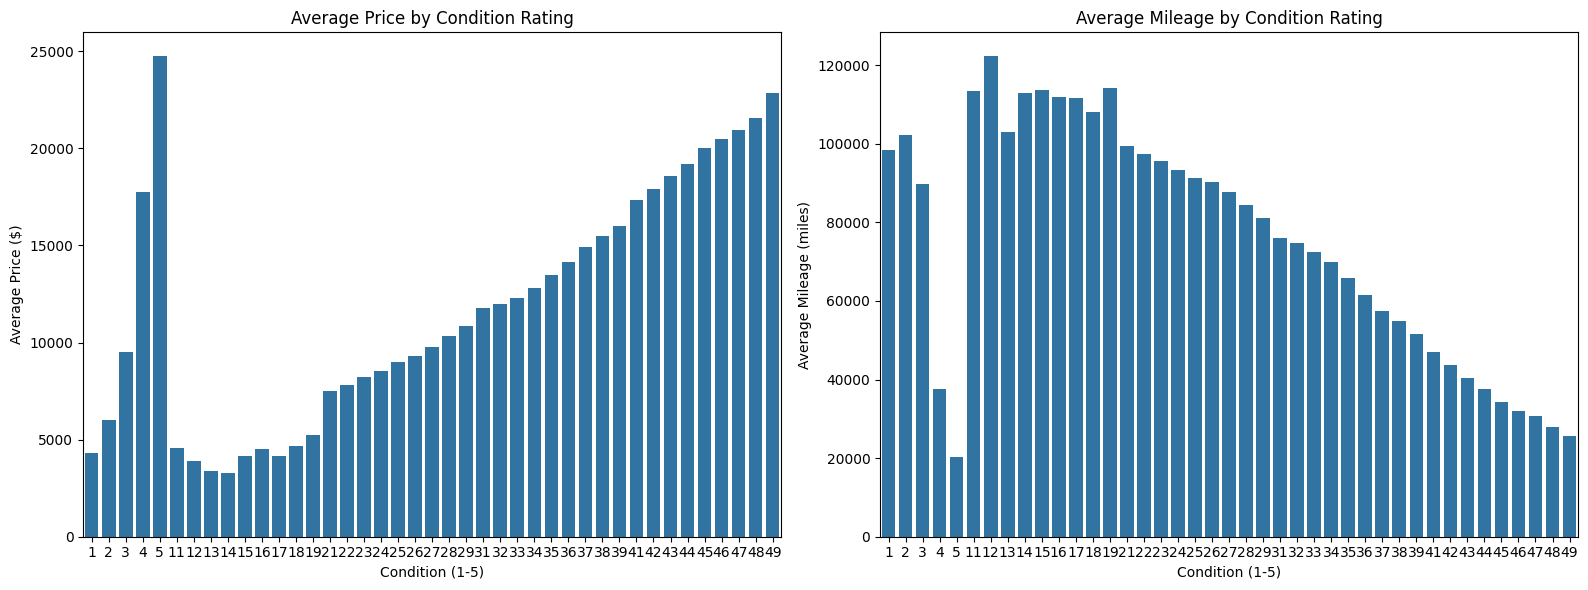

In [19]:
condition_analysis = data_clean.groupBy('condition').agg(
    mean('sellingprice').alias('avg_price'),
    mean('odometer').alias('avg_mileage'),
    count('*').alias('count')
).orderBy('condition').toPandas()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

sns.barplot(x='condition', y='avg_price', data=condition_analysis, ax=ax1)
ax1.set_title('Average Price by Condition Rating')
ax1.set_xlabel('Condition (1-5)')
ax1.set_ylabel('Average Price ($)')

sns.barplot(x='condition', y='avg_mileage', data=condition_analysis, ax=ax2)
ax2.set_title('Average Mileage by Condition Rating')
ax2.set_xlabel('Condition (1-5)')
ax2.set_ylabel('Average Mileage (miles)')

plt.tight_layout()
plt.show()

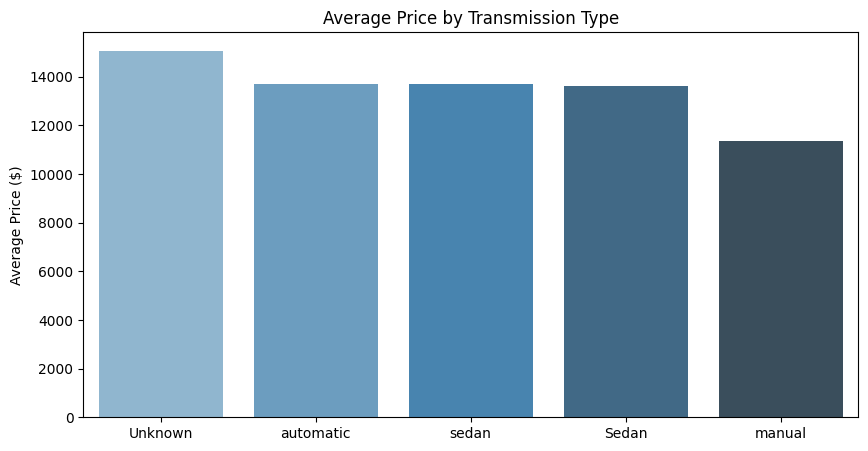

In [20]:
transmission_df = data_clean.groupBy("transmission").agg(
    mean("sellingprice").alias("avg_price"),
    count("*").alias("count")
).orderBy("avg_price", ascending=False).toPandas()

plt.figure(figsize=(10,5))
sns.barplot(x="transmission", y="avg_price", data=transmission_df, palette="Blues_d")
plt.title("Average Price by Transmission Type")
plt.xlabel("")
plt.ylabel("Average Price ($)")
plt.show()

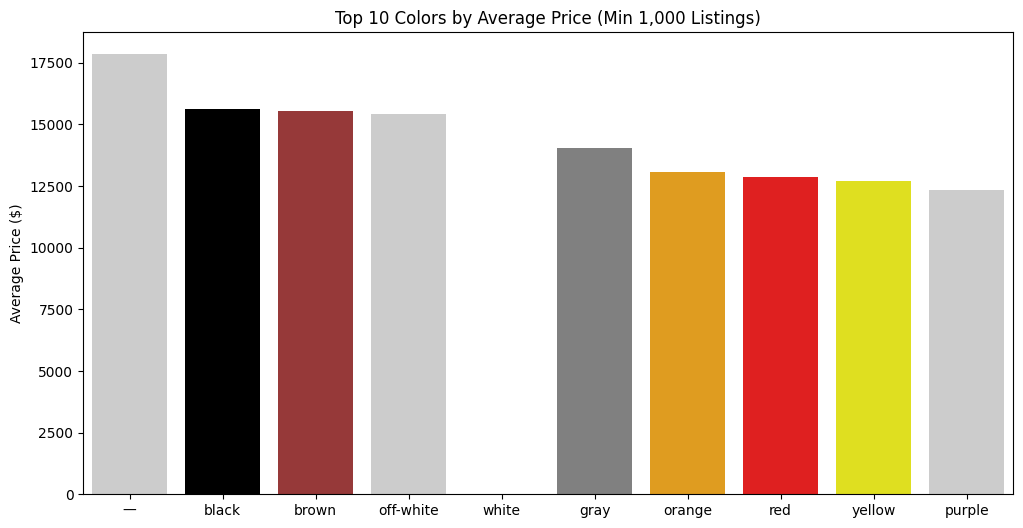

In [21]:
from pyspark.sql.functions import col, mean, count

# top colors by average price
color_df = data_clean.groupBy("color").agg(
    mean("sellingprice").alias("avg_price"),
    count("*").alias("count")
).filter(col("count") > 1000).orderBy("avg_price", ascending=False).limit(10).toPandas()

# Creating a color mapping dictionars
color_palette = {
    "white": "#FFFFFF",
    "black": "#000000",
    "silver": "#C0C0C0",
    "gray": "#808080",
    "red": "#FF0000",
    "blue": "#0000FF",
    "green": "#00FF00",
    "yellow": "#FFFF00",
    "orange": "#FFA500",
    "brown": "#A52A2A"
}

# Mapping colors to their hex values
colors = [color_palette.get(c.lower(), "#CCCCCC") for c in color_df["color"]]

plt.figure(figsize=(12,6))
sns.barplot(x="color", y="avg_price", data=color_df, palette=colors)
plt.title("Top 10 Colors by Average Price (Min 1,000 Listings)")
plt.xlabel("")
plt.ylabel("Average Price ($)")
plt.show()

# Feature Engineering

In [22]:
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_index", handleInvalid="keep")
            for c in ["make", "model", "transmission", "color"]]

assembler = VectorAssembler(
    inputCols=["year", "odometer", "mmr", "make_index", "model_index"],
    outputCol="features"
)

In [23]:
# Pipeline
pipeline = Pipeline(stages=indexers + [assembler])
data_prepped = pipeline.fit(data_clean).transform(data_clean)

In [24]:
# Train-Test Split
train_data, test_data = data_prepped.randomSplit([0.8, 0.2], seed=42)


# Model Training

## Linear Regression

In [25]:
lr = LinearRegression(featuresCol="features", labelCol="sellingprice")
lr_model = lr.fit(train_data)

In [26]:
# Predictions
lr_predictions = lr_model.transform(test_data)

In [27]:
# Evaluation
evaluator = RegressionEvaluator(labelCol="sellingprice", predictionCol="prediction")
print(f"RMSE: {evaluator.evaluate(lr_predictions, {evaluator.metricName: 'rmse'})}")
print(f"R²: {evaluator.evaluate(lr_predictions, {evaluator.metricName: 'r2'})}")

RMSE: 1818.9001396725089
R²: 0.9645123261024043


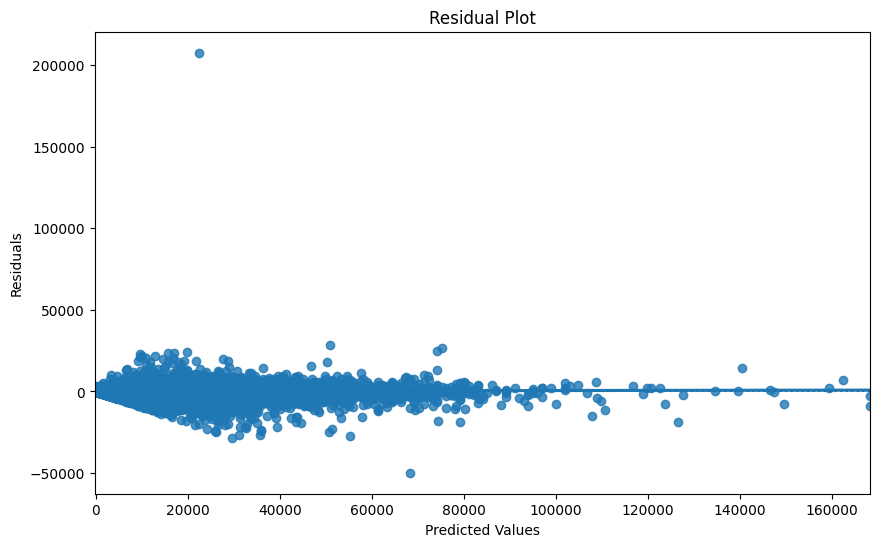

In [28]:
# Residual Plot
residuals = lr_predictions.select("prediction", "sellingprice").toPandas()
plt.figure(figsize=(10,6))
sns.residplot(x="prediction", y="sellingprice", data=residuals, lowess=True)
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

## Gradient Boosted Trees (GBT)

In [29]:
# Model Training
gbt = GBTRegressor(featuresCol="features", labelCol="sellingprice", maxIter=50, maxBins=1024) # Increased maxBins
gbt_model = gbt.fit(train_data)

# Predictions
gbt_predictions = gbt_model.transform(test_data)

# Evaluation
evaluator = RegressionEvaluator(labelCol="sellingprice", predictionCol="prediction")
print(f"RMSE: {evaluator.evaluate(gbt_predictions, {evaluator.metricName: 'rmse'})}")
print(f"R²: {evaluator.evaluate(gbt_predictions, {evaluator.metricName: 'r2'})}")

RMSE: 1888.4859177658873
R²: 0.9617450778542023
